<ipython-input-7-d4786c7336be>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['cmplnt_fr_dt'] + ' ' + df['cmplnt_fr_tm'], errors='coerce')


Safest location (lat, lon): (40.500207, -74.04732498994974)
Most dangerous location (lat, lon): (40.6379149396985, -74.01499176884423)

Hourly Safety at the 'Most Dangerous' Location:
    Hour  SafetyScore(1-100)
0      0            5.250315
1      1            4.866705
2      2            4.601457
3      3           15.835610
4      4           50.741604
5      5            5.722562
6      6            3.362737
7      7           52.593797
8      8           24.705213
9      9           26.107680
10    10           22.834917
11    11            9.419406
12    12           46.020468
13    13           31.563574
14    14           20.426342
15    15           52.115180
16    16            2.831545
17    17            3.102438
18    18           54.260361
19    19           43.278378
20    20            1.441601
21    21           11.312227
22    22            3.726819
23    23           18.118525


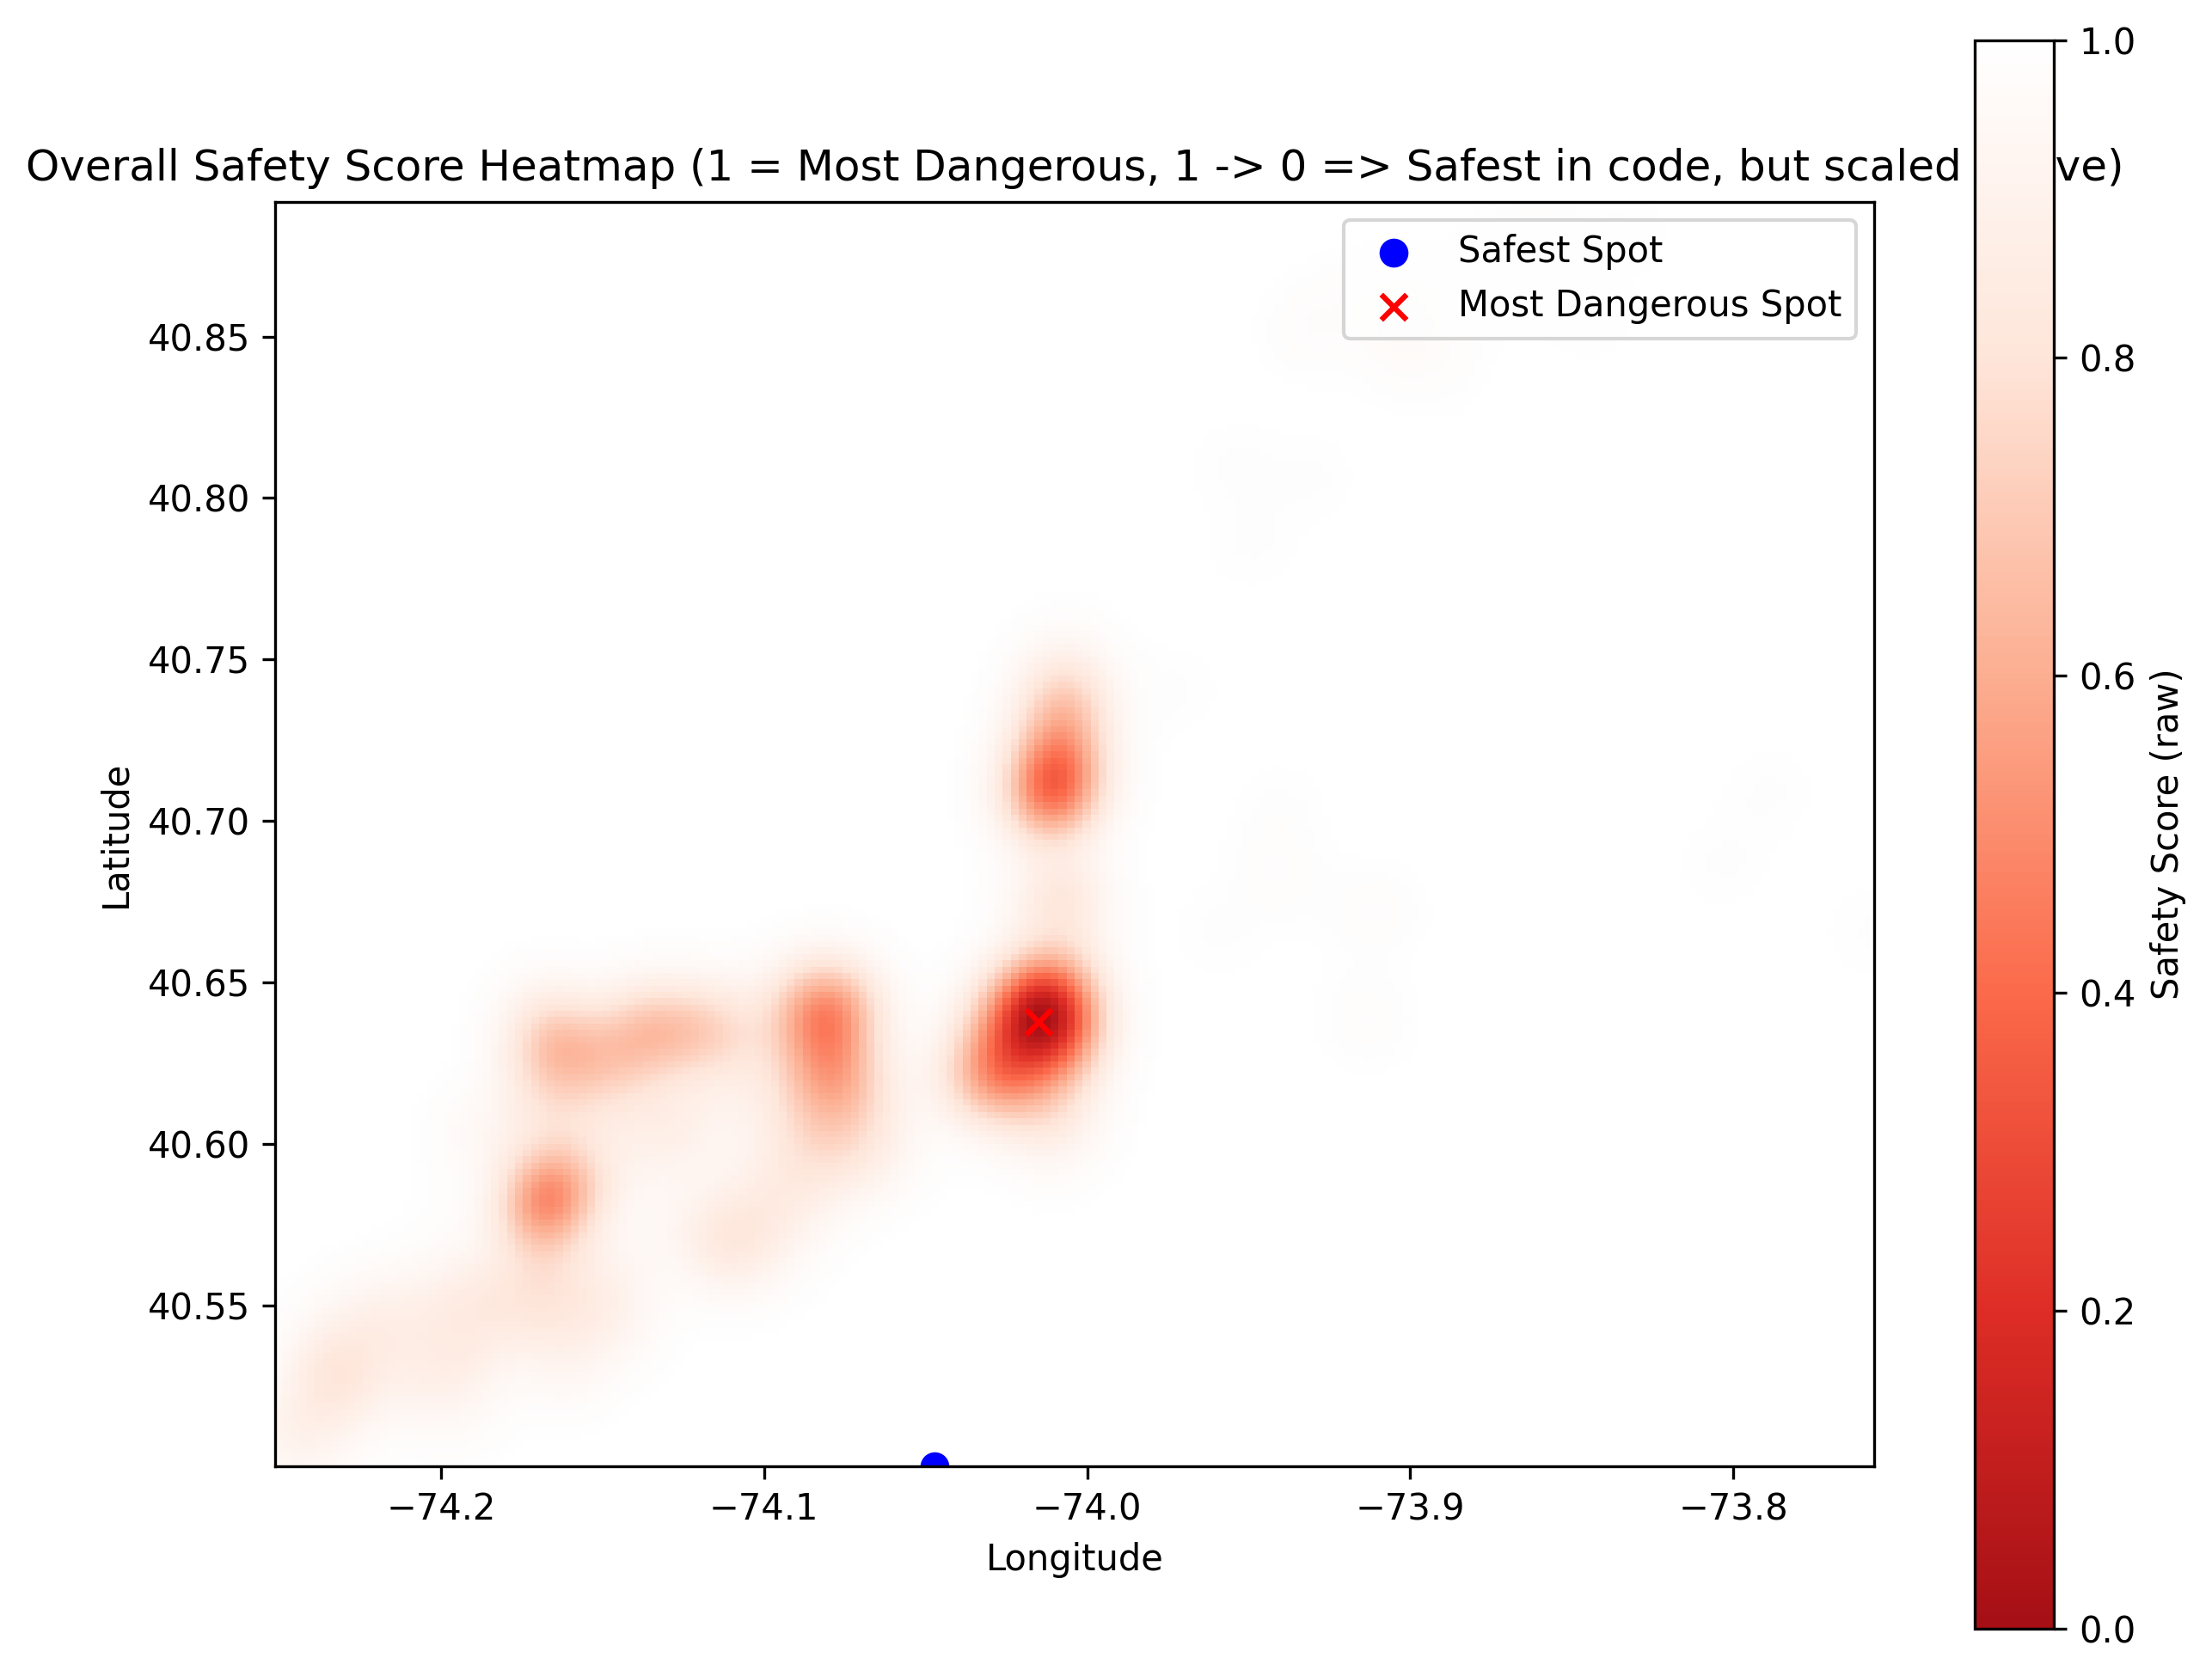

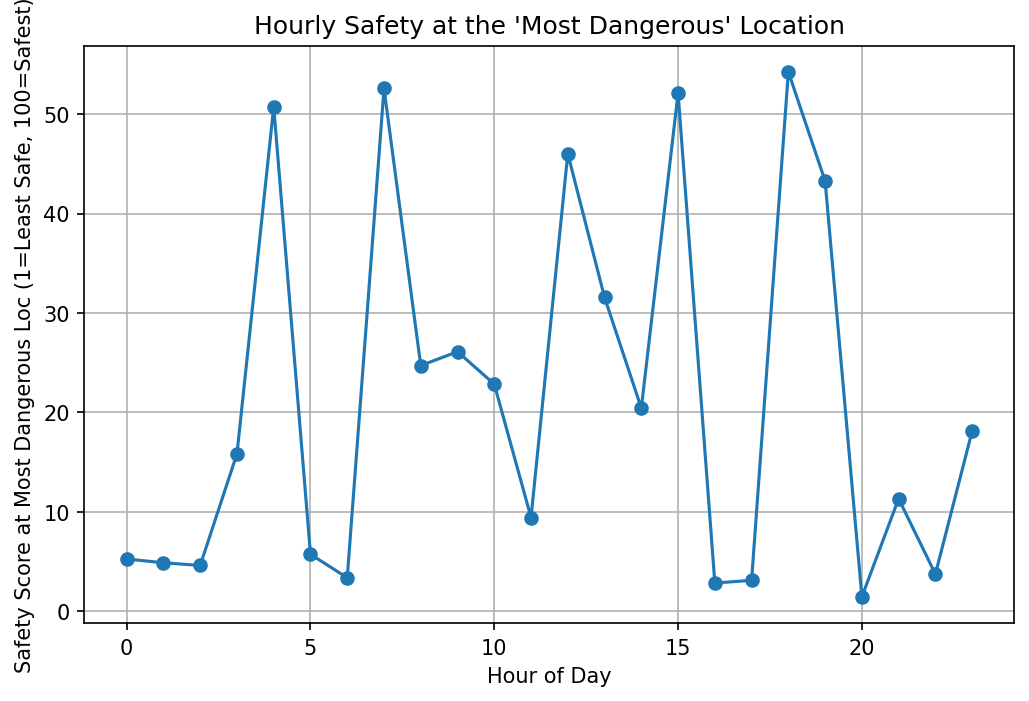

In [7]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Load the NYC crime JSON data
df = pd.read_json('NYC crime1234.json')

# Combine date and time columns into one datetime column.
df['date'] = pd.to_datetime(df['cmplnt_fr_dt'] + ' ' + df['cmplnt_fr_tm'], errors='coerce')

# Extract the hour from the datetime column
df['hour'] = df['date'].dt.hour

# Drop rows with missing latitude or longitude values
df = df.dropna(subset=['latitude', 'longitude'])


coords = df[['latitude', 'longitude']].values

# Fit a KDE model on all points
kde_all = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde_all.fit(coords)

# Create bounding box
n_points = 200
lon_min, lon_max = df['longitude'].min(), df['longitude'].max()
lat_min, lat_max = df['latitude'].min(), df['latitude'].max()
lon_lin = np.linspace(lon_min, lon_max, n_points)
lat_lin = np.linspace(lat_min, lat_max, n_points)
lon_grid, lat_grid = np.meshgrid(lon_lin, lat_lin)
grid_coords = np.vstack([lat_grid.ravel(), lon_grid.ravel()]).T

# Evaluate density, compute raw safety
log_density_all = kde_all.score_samples(grid_coords)
density_all = np.exp(log_density_all).reshape(lon_grid.shape)

norm_density_all = (density_all - density_all.min()) / (density_all.max() - density_all.min())
safety_score_all = 1 - norm_density_all  # Higher => safer

# Locate overall safest & most dangerous cells
max_idx = np.unravel_index(np.argmax(safety_score_all), safety_score_all.shape)
min_idx = np.unravel_index(np.argmin(safety_score_all), safety_score_all.shape)
safest_location = (lat_grid[max_idx], lon_grid[max_idx])
most_dangerous_location = (lat_grid[min_idx], lon_grid[min_idx])

print("Safest location (lat, lon):", safest_location)
print("Most dangerous location (lat, lon):", most_dangerous_location)


hour_safety_at_dangerous_loc = {}

most_dangerous_lat = float(most_dangerous_location[0])
most_dangerous_lon = float(most_dangerous_location[1])

for h in sorted(df['hour'].unique()):
    # Subset data for this hour
    df_hour = df[df['hour'] == h]
    # Skip hours with too few points
    if len(df_hour) < 5:
        continue

    # Fit KDE for hour h
    coords_h = df_hour[['latitude', 'longitude']].values
    kde_h = KernelDensity(bandwidth=0.01, kernel='gaussian')
    kde_h.fit(coords_h)

    # Evaluate density on bounding box for hour h
    log_density_h = kde_h.score_samples(grid_coords)
    density_h = np.exp(log_density_h).reshape(lon_grid.shape)

    # Get min/max density in bounding box
    dmin, dmax = density_h.min(), density_h.max()

    # Evaluate density at the "most dangerous" location
    # (We pass a 2D array with shape (1, 2) => [[lat, lon]])
    log_dangerous_loc = kde_h.score_samples(
        np.array([[most_dangerous_lat, most_dangerous_lon]])
    )
    density_dangerous_loc = np.exp(log_dangerous_loc)[0]

    # Normalize this single density to 0..1
    if dmax == dmin:

        norm_dangerous_loc = 0.5
    else:
        norm_dangerous_loc = (density_dangerous_loc - dmin) / (dmax - dmin)

    # Convert to raw safety in [0..1]
    raw_safety = 1 - norm_dangerous_loc

    scaled_safety = 1 + raw_safety * 99

    hour_safety_at_dangerous_loc[h] = scaled_safety

# Create a DataFrame from these hour-based scores
dangerous_loc_df = pd.DataFrame(
    list(hour_safety_at_dangerous_loc.items()),
    columns=['Hour', 'SafetyScore(1-100)']
).sort_values('Hour')
print("\nHourly Safety at the 'Most Dangerous' Location:")
print(dangerous_loc_df)

my_colors = [
    '#a50f15',  #  red
    '#de2d26',
    '#fb6a4a',
    '#fcae91',
    '#fee5d9',
    '#ffffff'   # white
]
custom_reds = LinearSegmentedColormap.from_list('custom_reds', my_colors, N=256)

plt.figure(figsize=(10, 8), dpi=300)
plt.imshow(
    safety_score_all,
    extent=(lon_min, lon_max, lat_min, lat_max),
    origin='lower',
    cmap=custom_reds
)
plt.title('Overall Safety Score Heatmap (1 = Most Dangerous, 1 -> 0 => Safest in code, but scaled above)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Safety Score (raw)')
plt.scatter(
    [safest_location[1]], [safest_location[0]],
    color='blue', marker='o', s=50, label='Safest Spot'
)
plt.scatter(
    [most_dangerous_location[1]], [most_dangerous_location[0]],
    color='red', marker='x', s=50, label='Most Dangerous Spot'
)
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8, 5), dpi=150)
ax.plot(dangerous_loc_df['Hour'], dangerous_loc_df['SafetyScore(1-100)'],
        marker='o', linestyle='-')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Safety Score at Most Dangerous Loc (1=Least Safe, 100=Safest)')
ax.set_title("Hourly Safety at the 'Most Dangerous' Location")
ax.grid(True)

# # Show table below the plot
# table_vals = dangerous_loc_df.values
# table_cols = dangerous_loc_df.columns
# table = plt.table(cellText=table_vals,
#                   colLabels=table_cols,
#                   loc='bottom',
#                   cellLoc='center')
# plt.subplots_adjust(left=0.2, bottom=0.3)
# plt.show()